# Workload Characterization

## Introduction

### Import relevant modules

In [1]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing

# Utilities
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn
# import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'

#### Low level parameters

In [3]:
df_low = pd.read_csv('WC_report_server.csv', sep='\s+', skiprows=1)
df_low.rename(columns={'r':'procs_r', 'b':'procs_b',
                       'swpd':'memory_swpd', 'free':'memory_free', 'buff':'memory_buff', 'cache':'memory_cache', 
                       'si':'swap_si', 'so':'swap_so', 
                       'bi':'io_bi', 'bo':'io_bo',
                       'in':'system_in', 'cs':'system_cs',
                       'us':'cpu_us', 'sy':'cpu_sy', 'id':'cpu_id', 'wa':'cpu_wa', 'st':'cpu_st'
                      }, inplace=True)
df_low.head()

,procs_r,procs_b,memory_swpd,memory_free,memory_buff,memory_cache,swap_si,swap_so,io_bi,io_bo,system_in,system_cs,cpu_us,cpu_sy,cpu_id,cpu_wa,cpu_st
0,5,0,367104,148460,42008,898668,10,101,894,2866,1623,1345,25,13,53,9,0
1,1,0,367104,150476,42016,898636,40,0,60,0,456,895,85,15,0,0,0
2,2,0,367104,150700,42016,898636,0,0,0,0,447,734,84,16,0,0,0
3,2,0,367104,146948,42024,898628,0,0,0,124,430,751,83,17,0,0,0
4,1,0,367104,147704,42024,898636,0,0,0,0,413,694,81,19,0,0,0


In [4]:
print('The dataset contains', df_low.shape[1], 'columns and', df_low.shape[0], 'rows')

The dataset contains 17 columns and 315 rows


# High level parameters

## Read data

In [5]:
df_high = pd.read_csv('WC_report_client.csv')
df_high.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect
0,1609320468373,109,HTTP Request - Repubblica Home,200,OK,Thread Group - Fast 2-1,text,True,NaN,387753,135,1,3,http://192.168.56.101/RepubblicaHome.html,58,0,32
1,1609320468373,109,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow 1-1,text,True,NaN,387753,135,1,3,http://192.168.56.101/RepubblicaHome.html,58,0,32
2,1609320468374,125,HTTP Request - Reddit Home,200,OK,Thread Group - Home 3-1,text,True,NaN,911062,131,1,3,http://192.168.56.101/RedditHome.html,92,0,32
3,1609320468662,11,HTTP Request - Reddit Home,200,OK,Thread Group - Slow 1-2,text,True,NaN,911062,131,2,4,http://192.168.56.101/RedditHome.html,3,0,1
4,1609320468682,6,HTTP Request - Repubblica Home,200,OK,Thread Group - Fast 2-2,text,True,NaN,387753,135,2,5,http://192.168.56.101/RepubblicaHome.html,2,0,1


In [6]:
print('The dataset contains', df_high.shape[1], 'columns and', df_high.shape[0], 'rows')

The dataset contains 17 columns and 40416 rows


In [7]:
df_high['success'].all()

True

In [8]:
df_high.loc[df_high['label'].str.contains('Wikipedia'), 'resourceType'] = 'small'
df_high.loc[df_high['label'].str.contains('Repubblica'), 'resourceType'] = 'medium'
df_high.loc[df_high['label'].str.contains('Reddit'), 'resourceType'] = 'large'

df_high.loc[df_high['threadName'].str.contains('Slow'), 'threadType'] = 'slow'
df_high.loc[df_high['threadName'].str.contains('Fast'), 'threadType'] = 'fast'
df_high.loc[df_high['threadName'].str.contains('Home'), 'threadType'] = 'home'

df_high.head()

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,failureMessage,bytes,sentBytes,grpThreads,allThreads,URL,Latency,IdleTime,Connect,resourceType,threadType
0,1609320468373,109,HTTP Request - Repubblica Home,200,OK,Thread Group - Fast 2-1,text,True,NaN,387753,135,1,3,http://192.168.56.101/RepubblicaHome.html,58,0,32,medium,fast
1,1609320468373,109,HTTP Request - Repubblica Home,200,OK,Thread Group - Slow 1-1,text,True,NaN,387753,135,1,3,http://192.168.56.101/RepubblicaHome.html,58,0,32,medium,slow
2,1609320468374,125,HTTP Request - Reddit Home,200,OK,Thread Group - Home 3-1,text,True,NaN,911062,131,1,3,http://192.168.56.101/RedditHome.html,92,0,32,large,home
3,1609320468662,11,HTTP Request - Reddit Home,200,OK,Thread Group - Slow 1-2,text,True,NaN,911062,131,2,4,http://192.168.56.101/RedditHome.html,3,0,1,large,slow
4,1609320468682,6,HTTP Request - Repubblica Home,200,OK,Thread Group - Fast 2-2,text,True,NaN,387753,135,2,5,http://192.168.56.101/RepubblicaHome.html,2,0,1,medium,fast


## Data analysis

In [9]:
df_high.describe()

,timeStamp,elapsed,responseCode,failureMessage,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
count,4.041600e+04,40416.000000,40416.0,0.0,40416.000000,40416.000000,40416.000000,40416.000000,40416.000000,40416.0,40416.000000
mean,1.609321e+12,10.899273,200.0,NaN,453445.221002,133.329028,47.048372,127.944898,5.037609,0.0,0.023308
std,8.349091e+04,18.892921,0.0,NaN,331257.134464,1.708763,7.498846,11.227800,12.355871,0.0,0.380004
min,1.609320e+12,0.000000,200.0,NaN,78455.000000,131.000000,1.000000,1.000000,0.000000,0.0,0.000000
25%,1.609321e+12,3.000000,200.0,NaN,93219.000000,131.000000,50.000000,130.000000,1.000000,0.0,0.000000
50%,1.609321e+12,6.000000,200.0,NaN,387752.000000,134.000000,50.000000,130.000000,1.000000,0.0,0.000000
75%,1.609321e+12,11.000000,200.0,NaN,857514.000000,135.000000,50.000000,130.000000,4.000000,0.0,0.000000
max,1.609321e+12,575.000000,200.0,NaN,911062.000000,135.000000,50.000000,130.000000,390.000000,0.0,32.000000


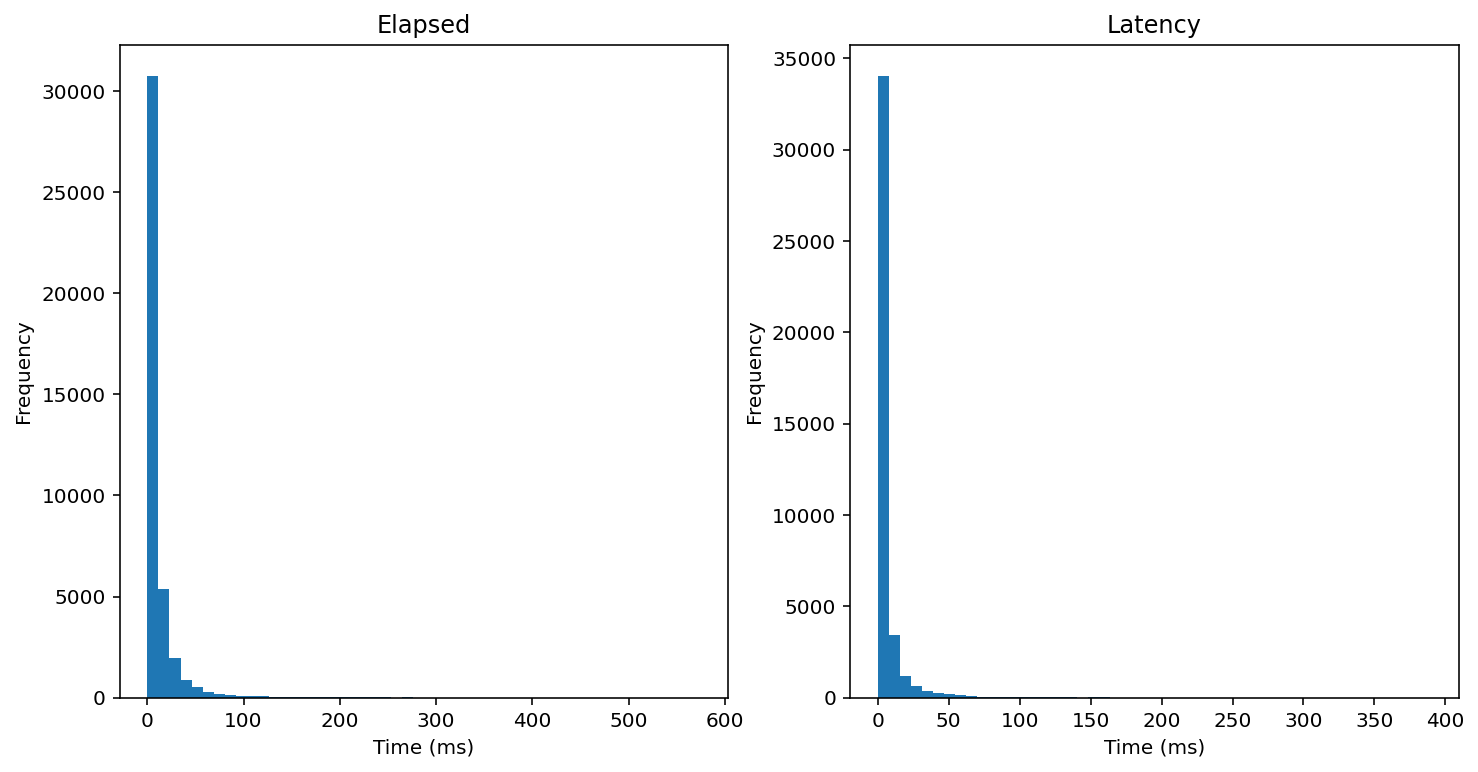

In [10]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.elapsed.plot.hist(bins=50, ax=ax0)
df_high.Latency.plot.hist(bins=50, ax=ax1)

ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed), 5))

ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
# ax1.set_xticks(np.arange(0, max(df_high.Latency), 5))

plt.show()

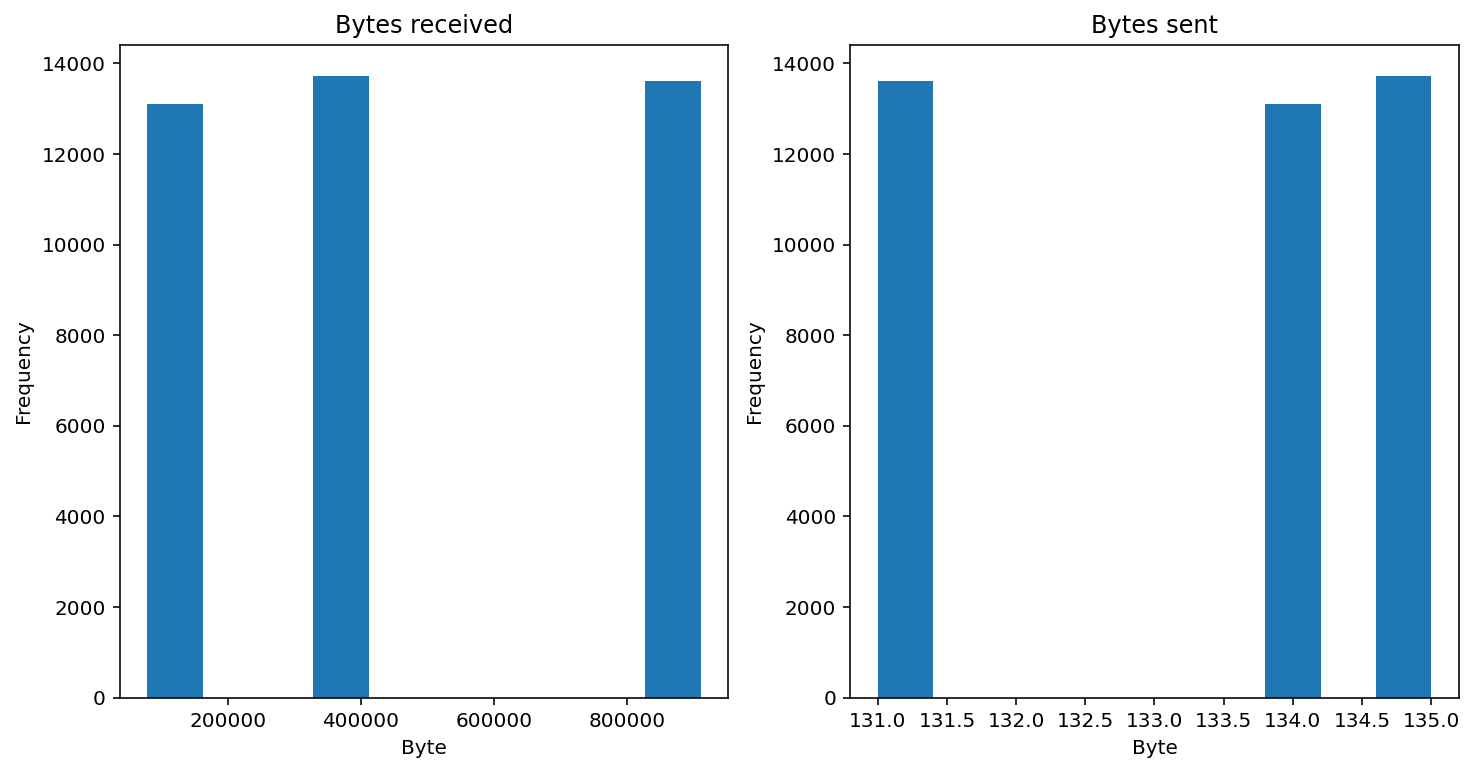

In [11]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.bytes.plot.hist(ax=ax0)
df_high.sentBytes.plot.hist(ax=ax1)

ax0.set_title('Bytes received')
ax0.set_xlabel('Byte')

ax1.set_title('Bytes sent')
ax1.set_xlabel('Byte')

plt.show()

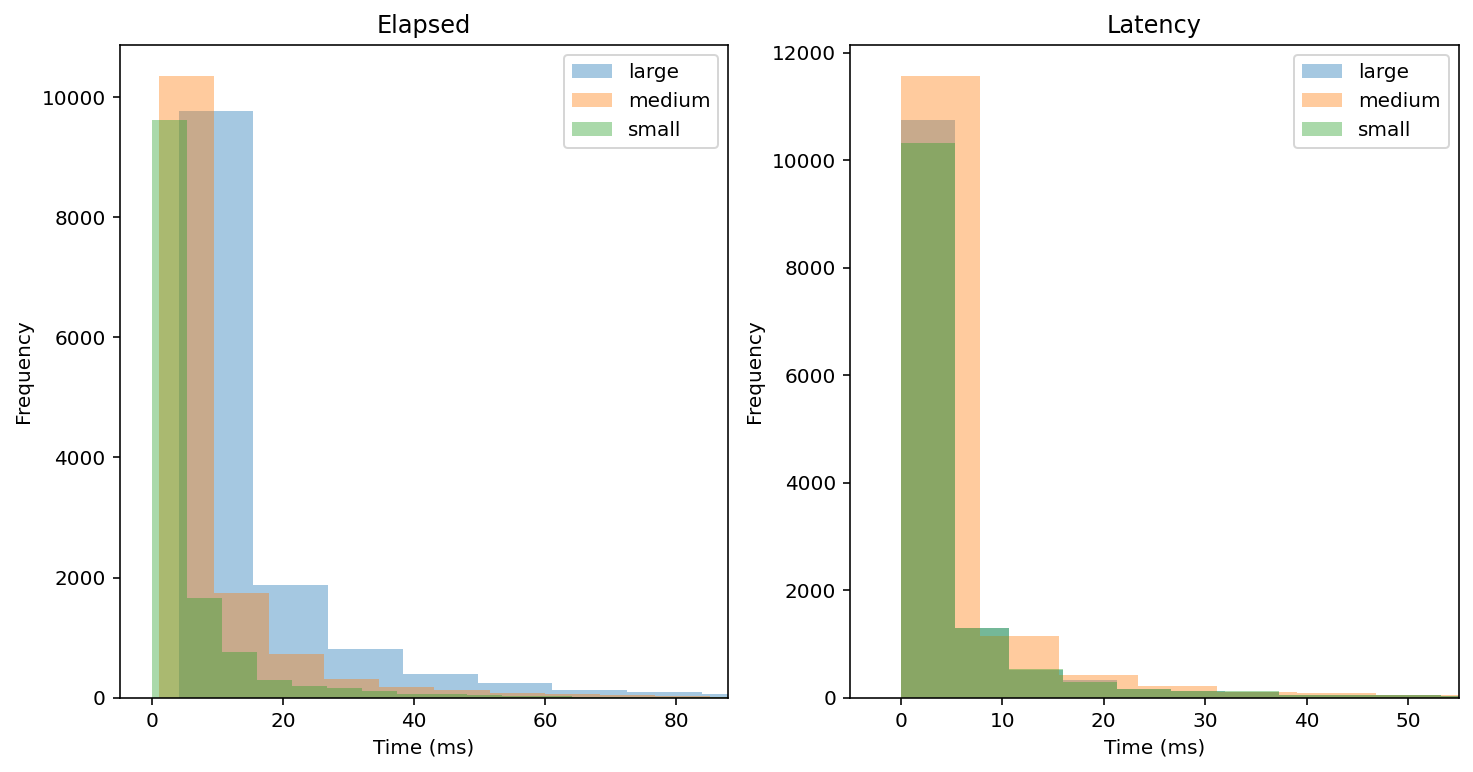

In [12]:
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_high.groupby(by='resourceType').elapsed.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax0)
df_high.groupby(by='resourceType').Latency.plot.hist(bins=50, alpha=0.4, legend=True, ax=ax1)

x_max = df_high.quantile(q=0.99).elapsed
ax0.set_xlim(-5,x_max)
ax0.set_title('Elapsed')
ax0.set_xlabel('Time (ms)')
# ax0.set_xticks(np.arange(0, max(df_high.elapsed)+1, 5))

x_max = df_high.quantile(q=0.99).Latency
ax1.set_xlim(-5,x_max)
ax1.set_title('Latency')
ax1.set_xlabel('Time (ms)')
# ax1.set_xticks(np.arange(0, max(df_high.Latency)+1, 5))

plt.show()

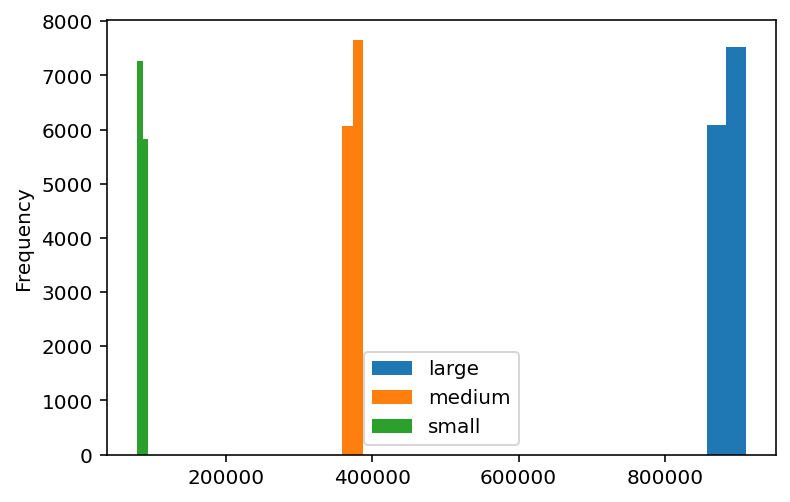

In [13]:
df_high.groupby(by='resourceType').bytes.plot.hist(bins=2, alpha=1, legend=True)

plt.show()

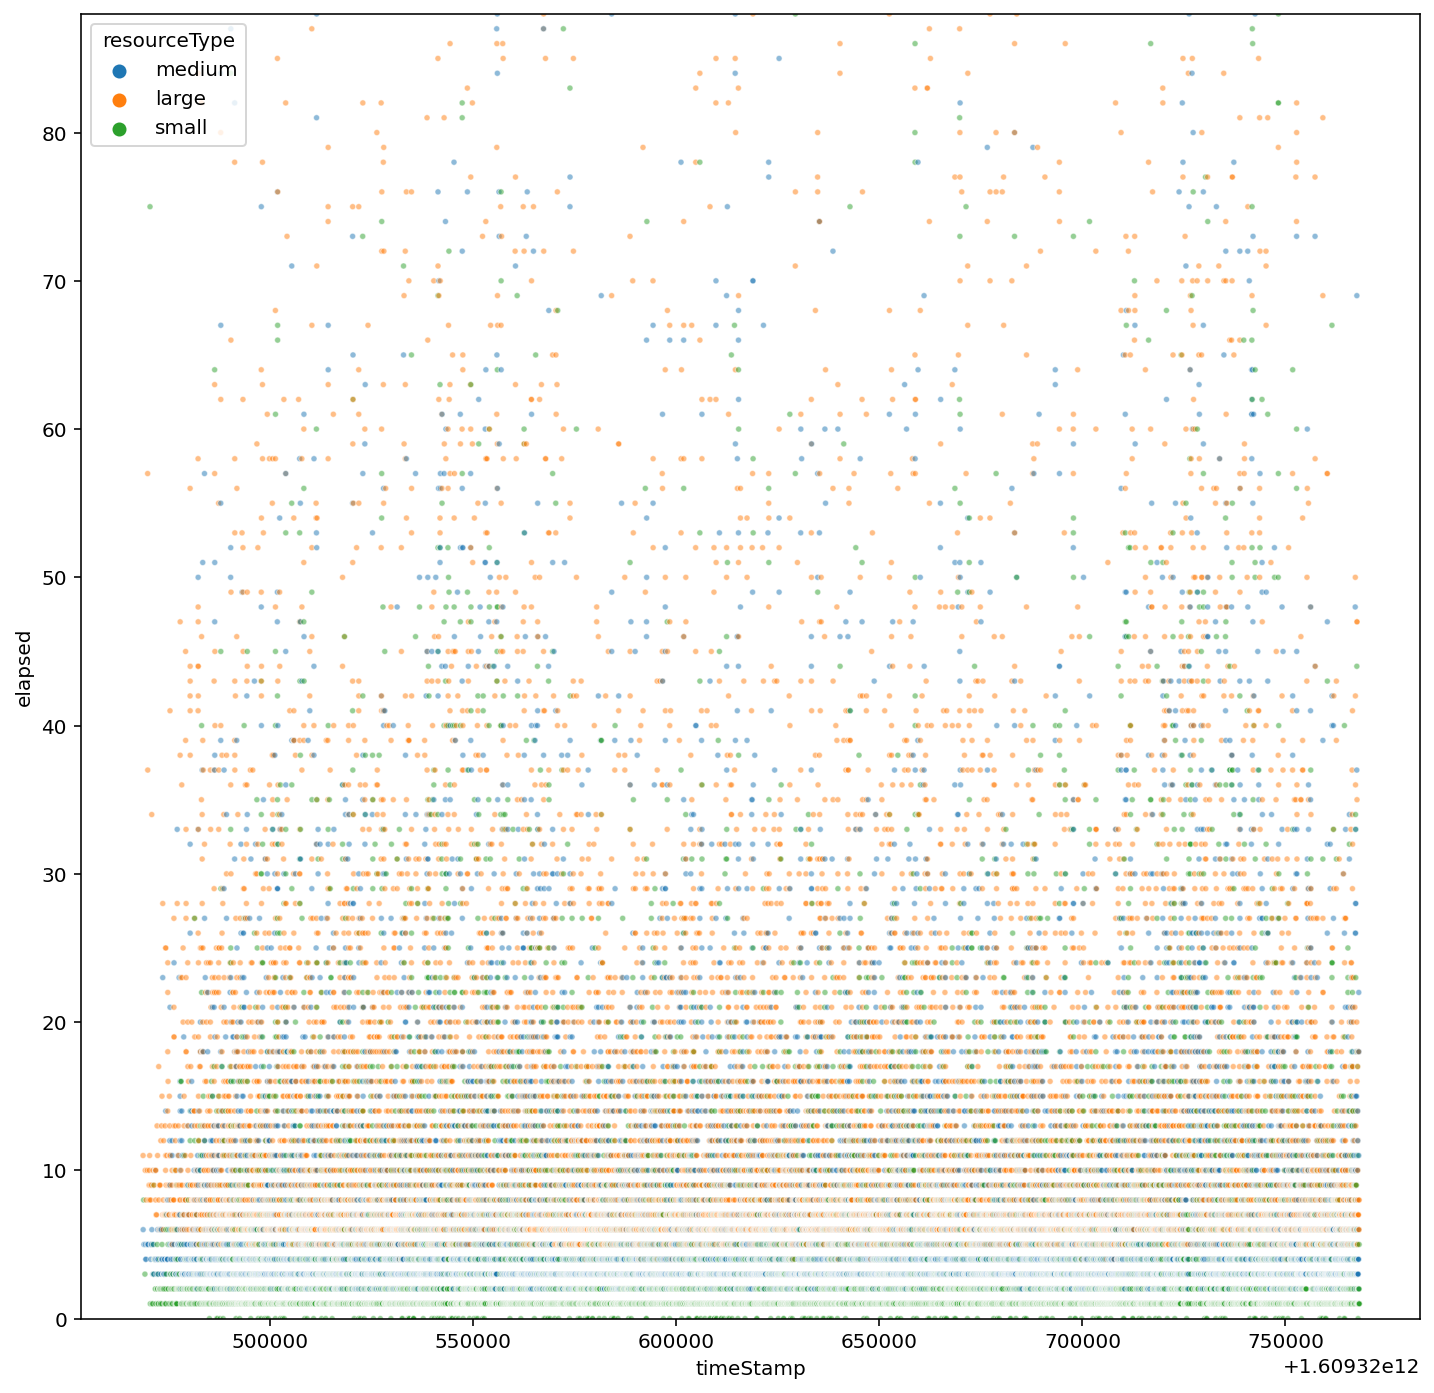

In [14]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, marker='.', alpha=.5)
y_max = df_high.quantile(q=0.99).elapsed
plt.ylim(0,y_max)
plt.show()

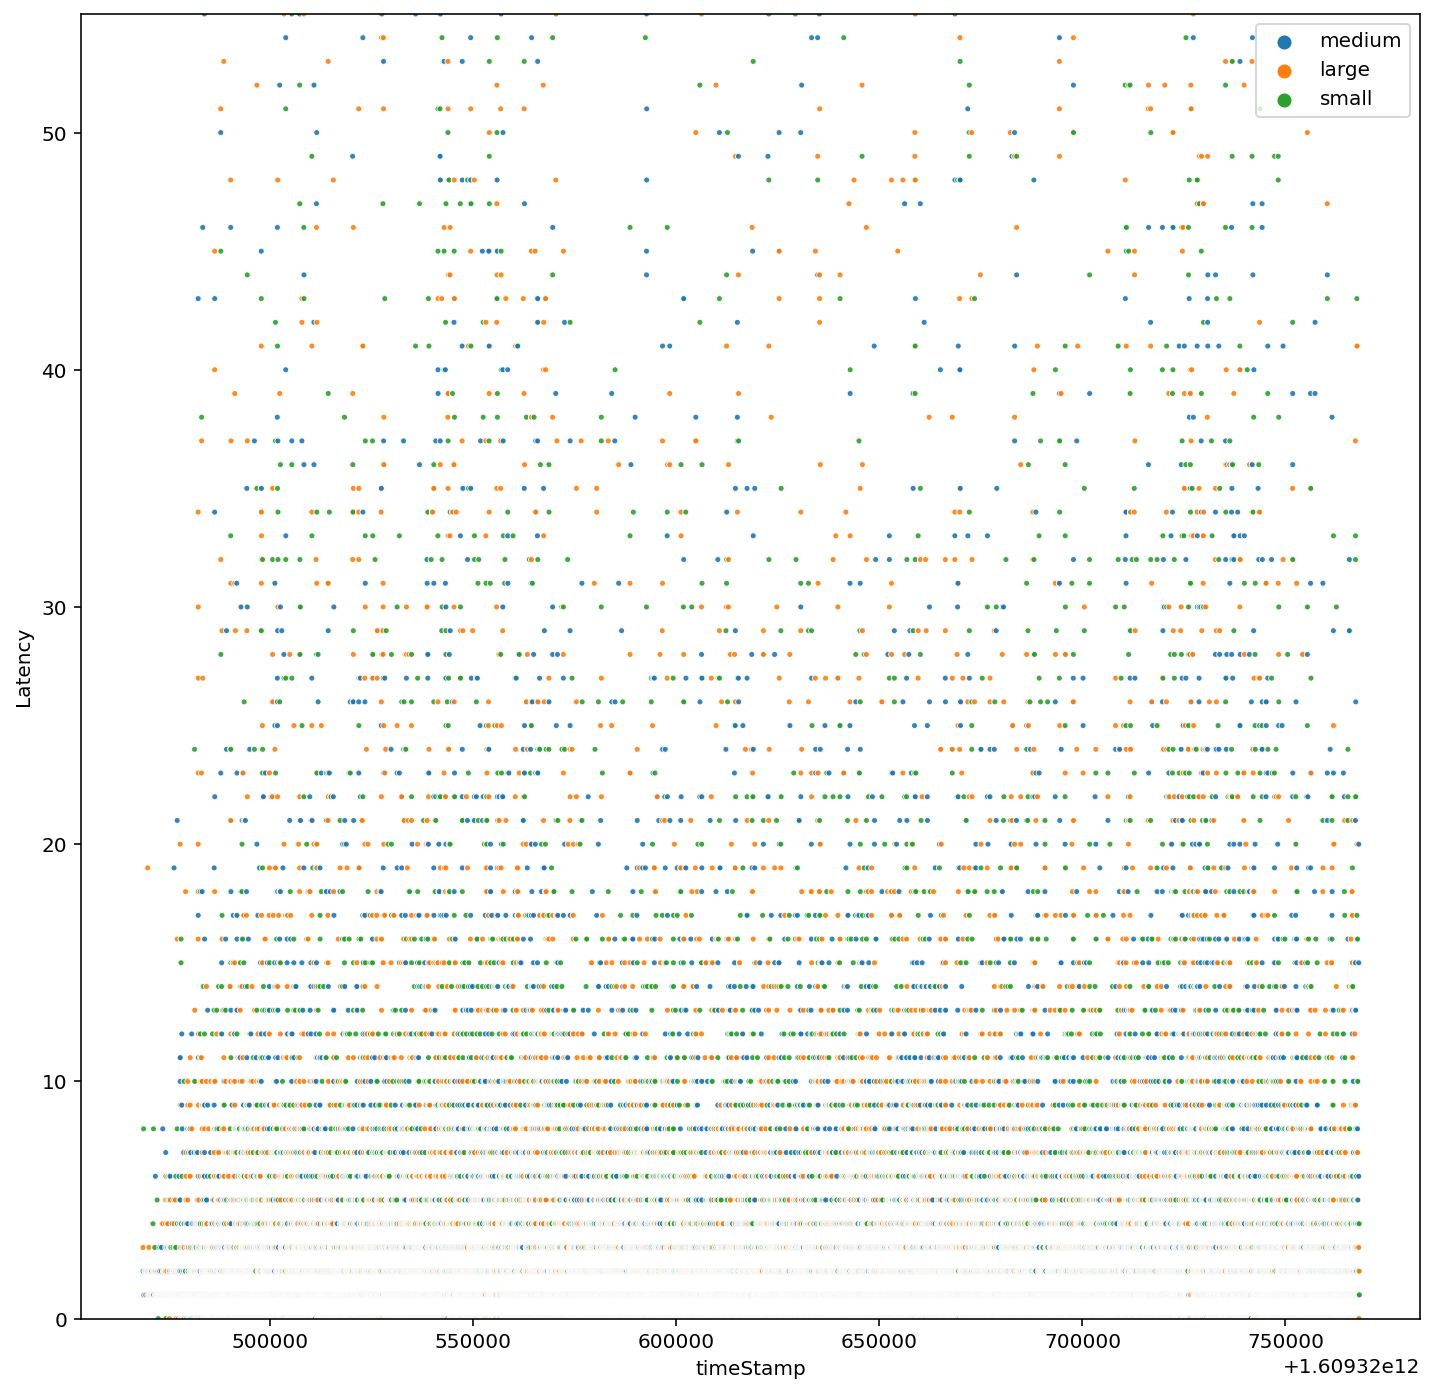

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, marker='.', alpha=.9)
y_max = df_high.quantile(q=0.99).Latency
plt.legend(loc='upper right')
plt.ylim(0,y_max)
plt.show()

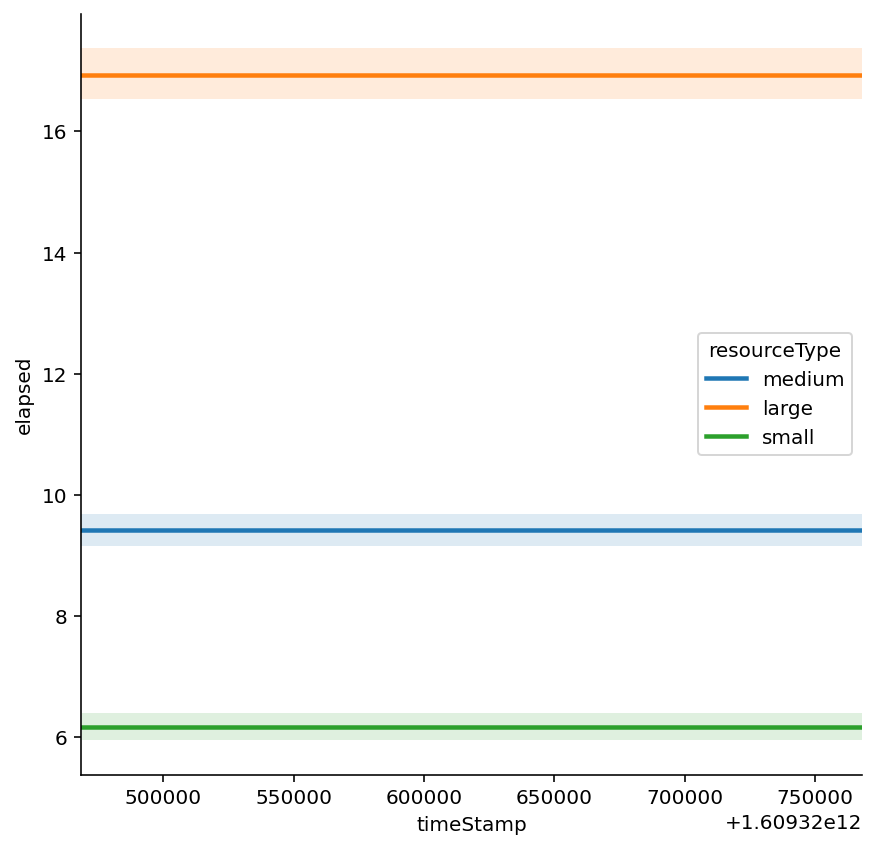

In [16]:
sns.lmplot(x='timeStamp', y='elapsed', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=6)
plt.show()

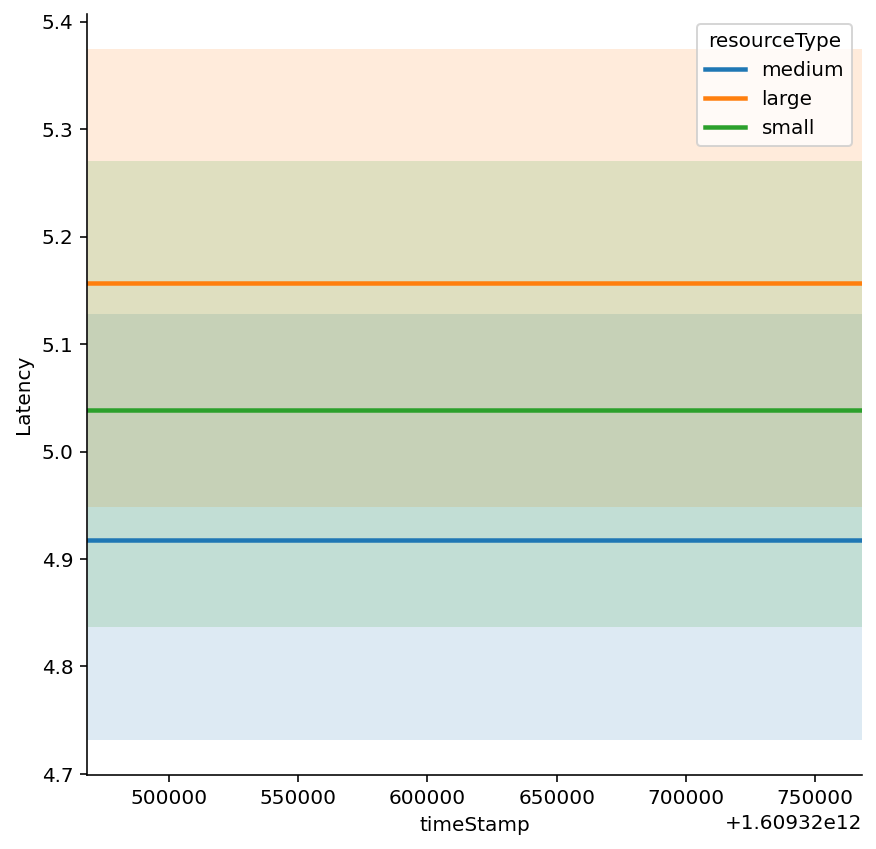

In [17]:
sns.lmplot(x='timeStamp', y='Latency', hue='resourceType', data=df_high, markers='.', legend_out=False, scatter=False, height=6)
plt.show()

## PCA

### Preprocessing

#### Remove nominal columns

In [18]:
df_high_pre = df_high.select_dtypes(include=['int64']).copy().drop(columns='responseCode')
df_high_pre.head()

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect
0,1609320468373,109,387753,135,1,3,58,0,32
1,1609320468373,109,387753,135,1,3,58,0,32
2,1609320468374,125,911062,131,1,3,92,0,32
3,1609320468662,11,911062,131,2,4,3,0,1
4,1609320468682,6,387753,135,2,5,2,0,1


In [19]:
thread_type_encoder = preprocessing.LabelEncoder()
thread_type_encoder.fit(['slow','fast','home'])

df_high_pre['threadType'] = thread_type_encoder.transform(df_high['threadType'])
df_high_pre

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,IdleTime,Connect,threadType
0,1609320468373,109,387753,135,1,3,58,0,32,0
1,1609320468373,109,387753,135,1,3,58,0,32,2
2,1609320468374,125,911062,131,1,3,92,0,32,1
3,1609320468662,11,911062,131,2,4,3,0,1,2
4,1609320468682,6,387753,135,2,5,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...
40411,1609320768123,1,93218,134,5,5,1,0,0,0
40412,1609320768124,2,78491,134,4,4,1,0,0,0
40413,1609320768143,8,857514,131,3,3,2,0,0,0
40414,1609320768146,5,78490,134,3,3,4,0,0,0


#### Remove constant components

In [20]:
df_const = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() == 1]]
df_const.head()

,IdleTime
0,0
1,0
2,0
3,0
4,0


In [21]:
df_high_pre = df_high_pre.loc[:,df_high_pre.columns[df_high_pre.nunique() != 1]]
df_high_pre.head()

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect,threadType
0,1609320468373,109,387753,135,1,3,58,32,0
1,1609320468373,109,387753,135,1,3,58,32,2
2,1609320468374,125,911062,131,1,3,92,32,1
3,1609320468662,11,911062,131,2,4,3,1,2
4,1609320468682,6,387753,135,2,5,2,1,0


#### Remove perfectly correlated components

In [22]:
df_corr = df_high_pre.corr()
df_corr

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect,threadType
timeStamp,1.000000,0.008781,-0.011382,0.012602,0.153374,0.232065,0.009202,-0.026778,-0.002439
elapsed,0.008781,1.000000,0.239202,-0.204439,-0.066295,0.016430,0.758963,0.079202,0.035517
bytes,-0.011382,0.239202,1.000000,-0.821159,-0.009021,-0.008859,0.005413,0.005892,-0.000247
sentBytes,0.012602,-0.204439,-0.821159,1.000000,-0.006556,0.003219,-0.007620,-0.005409,0.000297
grpThreads,0.153374,-0.066295,-0.009021,-0.006556,1.000000,0.572790,-0.044340,-0.082885,-0.098653
allThreads,0.232065,0.016430,-0.008859,0.003219,0.572790,1.000000,0.021191,-0.114908,-0.004693
Latency,0.009202,0.758963,0.005413,-0.007620,-0.044340,0.021191,1.000000,0.060764,0.010880
Connect,-0.026778,0.079202,0.005892,-0.005409,-0.082885,-0.114908,0.060764,1.000000,0.021827
threadType,-0.002439,0.035517,-0.000247,0.000297,-0.098653,-0.004693,0.010880,0.021827,1.000000


#### Normalize the components

In [23]:
x = df_high_pre.values

x_scaled = StandardScaler().fit_transform(x)

df_high_pre = pd.DataFrame(data=x_scaled, columns=df_high_pre.columns )
df_high_pre.head()

,timeStamp,elapsed,bytes,sentBytes,grpThreads,allThreads,Latency,Connect,threadType
0,-1.860421,5.192524,-0.198314,0.977896,-6.140803,-11.128310,4.286468,84.149379,-0.784888
1,-1.860421,5.192524,-0.198314,0.977896,-6.140803,-11.128310,4.286468,84.149379,1.446857
2,-1.860409,6.039412,1.381472,-1.363008,-6.140803,-11.128310,7.038230,84.149379,0.330985
3,-1.856959,0.005332,1.381472,-1.363008,-6.007448,-11.039244,-0.164912,2.570249,1.446857
4,-1.856720,-0.259321,-0.198314,0.977896,-6.007448,-10.950179,-0.245846,2.570249,-0.784888


### Perform PCA

In [24]:
pca = PCA()

princ_comp = pca.fit(df_high_pre.values)

In [25]:
d = pca.transform(df_high_pre.values)

c = [str(s) for s in range(princ_comp.n_components_)]
c = ['comp ' + s for s in c]

df_high_pca = pd.DataFrame(data=d, columns=c)
df_high_pca.head()

,comp 0,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,comp 7,comp 8
0,12.126109,28.368298,8.146805,8.948878,77.086820,15.865492,-0.448054,-0.206878,-0.696244
1,12.199340,28.589295,8.201131,11.037574,76.615588,16.393048,-0.205299,-0.240537,-0.717232
2,15.738922,28.036423,8.516524,9.803290,76.612477,16.110321,-0.122396,-1.955142,-0.879141
3,2.981407,11.484857,-3.776646,0.663240,0.965446,-2.139775,3.587988,-0.120994,-0.054892
4,0.671840,11.838639,-2.291848,-1.458583,1.402192,-2.610341,3.273644,0.354082,-0.426455


#### Explained variance

In [26]:
d = {'explained variance': princ_comp.explained_variance_, 'explained variance ratio': princ_comp.explained_variance_ratio_}

df_variance_PCA = pd.DataFrame(data=d)

df_variance_PCA['cumulative explained variance ratio'] = df_variance_PCA.cumsum()['explained variance ratio']
df_variance_PCA.head(10)

,explained variance,explained variance ratio,cumulative explained variance ratio
0,2.047127,0.227453,0.227453
1,1.716603,0.190729,0.418182
2,1.581137,0.175678,0.593859
3,1.007786,0.111973,0.705833
4,0.966766,0.107416,0.813249
5,0.882347,0.098036,0.911285
6,0.409494,0.045498,0.956783
7,0.218818,0.024313,0.981096
8,0.170144,0.018904,1.000000


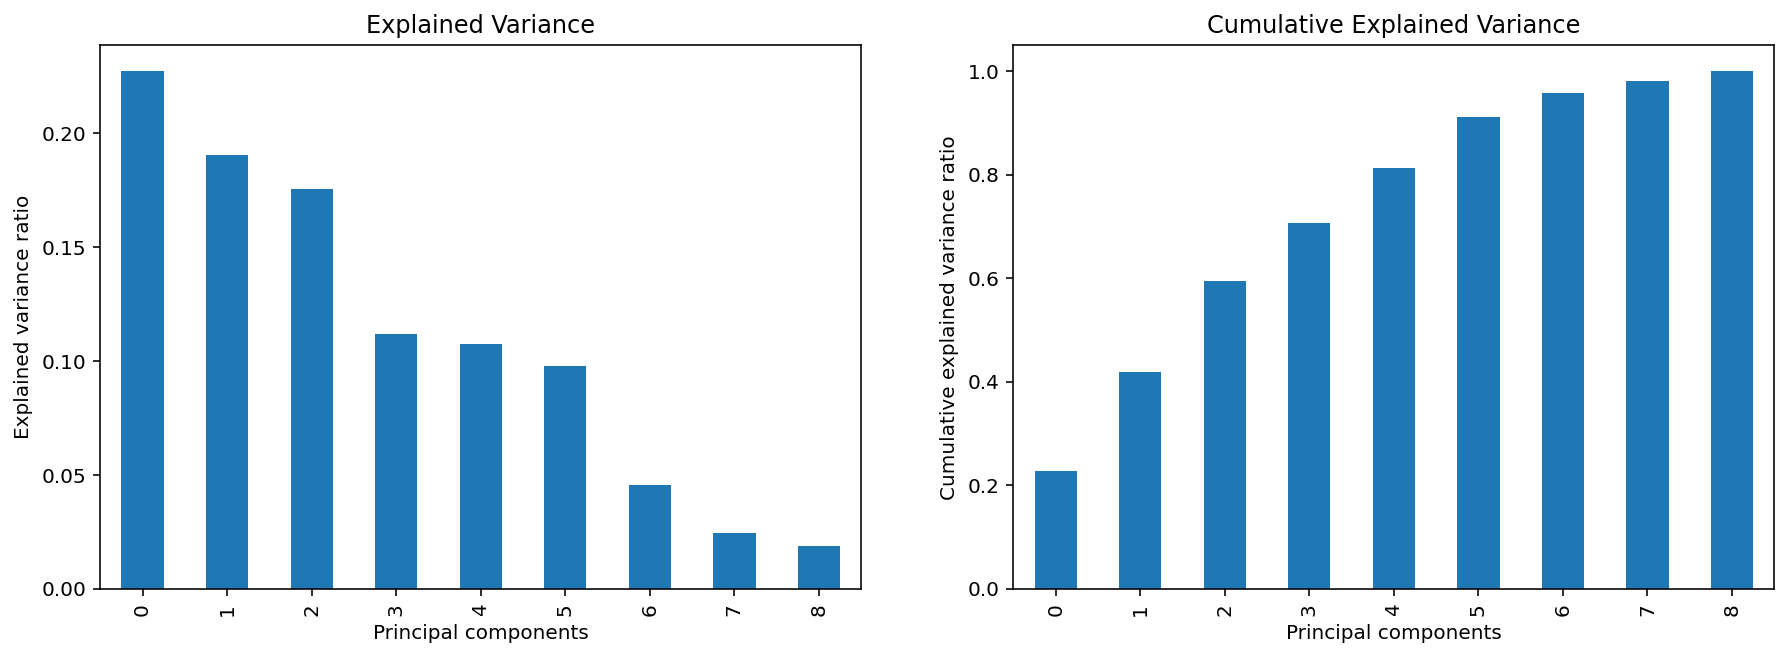

In [27]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

df_variance_PCA.plot.bar(y=['explained variance ratio'], ax=ax0, legend=False)
df_variance_PCA.plot.bar(y=['cumulative explained variance ratio'], ax=ax1, legend=False)

ax0.set_title('Explained Variance')
ax0.set_xlabel('Principal components')
ax0.set_ylabel('Explained variance ratio')

ax1.set_title('Cumulative Explained Variance')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative explained variance ratio')
plt.show()

## Clustering

### Select principal components

In [28]:
# nmin_comp = 4
# nmax_comp = 7
# n_comp = nmax_comp-nmin_comp+1

# nmax_cluster = 5

# array_dev_lost = np.zeros(shape=(nmax_cluster,n_comp))

# for i in tnrange(nmin_comp,nmax_comp+1, desc='outer loop'):

#     df_clustering = df_high_pca.iloc[:,0:i]

#     for j in tnrange(1,nmax_cluster+1, desc='inner loop'):
#         # clustering
#         clustering = AgglomerativeClustering(n_clusters=j)
#         clustering = clustering.fit(df_clustering.values)
#         df_clustering.loc[:,'cluster'] = clustering.labels_

#         # deviance PCA
#         df_pca = df_high_pca.iloc[:,0:i]
#         dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()

#         # deviance clustering 
#         n_elem = df_clustering.groupby('cluster').count().values[:,0]
#         centroids = df_clustering.groupby('cluster').mean()

#         # intra-cluster deviance
#         arr = np.zeros(shape=(j,1))
#         for k in range(j):
#             elem_k = df_clustering.loc[df_clustering['cluster'] == k].drop(columns='cluster')
#             arr[k] = elem_k.sub(centroids.loc[k,:]).pow(2).sum().sum()
#         dev_intra = arr.sum()

#         # inter-cluster deviance
#         dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
#         dev_inter

#         # deviance lost
#         dev_pca_ratio = dev_pca/dev_tot
#         dev_inter_ratio = dev_inter/dev_pca
#         dev_lost = 1 - dev_inter_ratio * dev_pca_ratio

#         array_dev_lost[j-1][i-n_comp+1] = dev_lost
        
# # array_dev_lost

In [29]:
# x = np.arange(1,nmax_cluster+1)

# plt.figure(figsize=(7,5))

# for i in range(nmin_comp,nmax_comp+1):
#     y_dev_lost = array_dev_lost[:,i-n_comp+1]
#     plt.plot(x, y_dev_lost)
    
# c = [str(s) for s in range(nmin_comp,nmax_comp+1)]
# c = [s + ' comp' for s in c]
    
# plt.title('Deviance lost')
# plt.ylabel('Deviance lost ratio')
# plt.xlabel('Number of clusters')
# plt.xticks(range(nmax_cluster+1))
# plt.yticks(np.linspace(0,y_dev_lost.max(),20))
# plt.grid(color='k', linestyle='-', linewidth=0.1)
# plt.legend(c)
# plt.show()


In [30]:
n_comp = 2
df_high_cl = df_high_pca.iloc[:,0:n_comp]
df_high_cl.head()

,comp 0,comp 1
0,12.126109,28.368298
1,12.199340,28.589295
2,15.738922,28.036423
3,2.981407,11.484857
4,0.671840,11.838639


### Perform clustering

In [ ]:
n_clusters = 3

clustering = AgglomerativeClustering(n_clusters=n_clusters, compute_full_tree=False)
clustering = clustering.fit(df_high_cl.values)

In [ ]:
df_clustered = df_high
df_clustered.loc[:,'cluster'] = clustering.labels_
df_clustered.head()

### 4.3. Synthetic workload
Clearly, Ward's method is the most appropriate for workload characterization: on one hand it allows to reduce the workload dimension and on the other hand it preserve most of the workload variance.
In this case, we started with a real workload of 3000 observations and now we have a workload of 10 observations, each of which is a random sample of the relative cluster. In the following section we will look at the variance (deviance) lost.

In [ ]:
df_synth = df_clustered.groupby('cluster').apply(lambda x: x.sample())
df_synth = df_synth.reset_index(level=0, col_level=2 , drop=True)
df_synth

## 5. Deviance
As we already said, we want a synthetic workload to be representative of the real one, in term of variability of the data. For this reason, we need to observ how both techniques used in the characterization process affect the worload variance.

Let's start by computing the total deviance of the workload.

In [ ]:
dev_tot = df_scaled.sub(df_scaled.mean()).pow(2).sum().sum()
dev_tot

### 5.1. Deviance after PCA
Now let's compute the deviance preserved by PCA.

In [ ]:
df_pca = df_princ_comp.iloc[:,0:3]
dev_pca = df_pca.sub(df_pca.mean()).pow(2).sum().sum()
dev_pca

In [ ]:
dev_pca_ratio = dev_pca/dev_tot
dev_pca_ratio

As expected, considering just three of the principal components, we are including the 84% of the total deviance.

### 5.2. Deviance after clustering
Now we can see how clustering affects deviance of data. First of all, total deviance of clustered data (deviance after PCA) can be written as:<br>
<center>$d_{PCA} = d_{intra} + d_{inter}$</center>

where $d_{intra}$ and $d_{inter}$ are called respectively *intra-cluster deviance* and *inter-cluster deviance*.
Since we consider just one random point for each cluster, $d_{intra}$ is the amount of deviance lost form PCA deviance, whereas $d_{inter}$ it the amount of deviance preserved.

#### Intra-cluster deviance
Intra-cluster deviance is the sum of the deviance of each cluster:<br>
<center>$d_{intra} = \sum_{k=1}^{K} \sum_{i=1}^{n_k} ||x_i - \overline x_k||$</center>

where:
- $K$ is the number of clusters
- $n_k$ is the number of points of cluster $k$
- $x_i$ is the $i$-th point of cluster $k$
- $\overline x_k$ is the centroid of cluster $k$

In [ ]:
df_clustering.loc[:,'cluster'] = clustering.labels_
n_elem = df_clustering.groupby('cluster').count().values[:,0]
centroids = df_clustering.groupby('cluster').mean()

In [ ]:
arr = np.zeros(shape=(n_clusters,1))

for i in range(n_clusters):
    elem_i = df_clustering.loc[df_clustering['cluster'] == i].drop(columns='cluster')
    arr[i] = elem_i.sub(centroids.loc[i,:]).pow(2).sum().sum()
    
dev_intra = arr.sum()
dev_intra

In [ ]:
dev_intra_ratio = dev_intra/dev_pca
dev_intra_ratio

#### Inter-cluster deviance
Inter-cluster deviance is defined as:<br>
<center>$d_{inter} = \sum_{k=1}^{K} n_k ||\overline x_k - \overline x||$</center>

where:
- $K$ is the number of clusters
- $n_k$ is the number of points of cluster $k$
- $\overline x_k$ is the centroid of cluster $k$
- $\overline x_ = \frac{1}{n} \sum_{i=1}^{n} x_i$ is the mean of all data points.

In [ ]:
dev_inter = centroids.sub(df_clustering.mean()).pow(2).mul(n_elem, axis=0).sum().sum()
dev_inter

In [ ]:
dev_inter_ratio = dev_inter/dev_pca
dev_inter_ratio

Before moving forward, let's check that the sum of intra and inter-cluster deviance is equal to the deviance preserved by PCA.

In [ ]:
print('dev_intra + dev_inter = ' + str(dev_intra + dev_inter))
print('dev_pca = ' + str(dev_pca))

### 5.3. Loss of deviance
Finally we can compute the total loss of deviance due to both PCA and clustering.

#### 1st approach 
Deviance lost can be seen as the sum of deviance lost because of PCA and deviance lost because of clustering (intra-cluster deviance), which is relative to deviance preserved by PCA.

In [ ]:
dev_lost_ratio = (1-dev_pca_ratio) + dev_intra_ratio * dev_pca_ratio
dev_lost_ratio

#### 2nd approach
Deviance lost can be seen as total deviance minus total deviance preserved, which is the product of deviance preserved by PCA and deviance preserved by clustering (inter-cluster deviance).

In [ ]:
dev_lost_ratio = 1 - dev_inter_ratio * dev_pca_ratio
dev_lost_ratio